Vary this

1. Model params/layers
2. No. training epochs
3. Shuffling training data
4. Reduce/filter away None events
5. Change the size and position of the event start/end range


Also try moving all the events markers to line up correctly. Maybe aim to have the markers align in the first peak/trough?


In [1]:
import numpy as np
import pandas as pd
import wave
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from data_ml import get_ml_data
from data_plot import plot_samples_events_individual

In [2]:
BRAINBOX_SAMPLE_RATE = 10000

EVENT_ID_MAP = {
    None: 0,
    "L": 1,
    "R": 2,
    "S": 3,
}
EVENT_ID_LETTER_MAP = {EVENT_ID_MAP[i]:i for i in EVENT_ID_MAP}

EVENT_COLOR_MAP = {
    None: "black",
    "L": "red",
    "R": "blue",
    "S": "green",
}

EVENT_ID_NAME_MAP = {
    0: "Nothing",
    1: "Left Wink",
    2: "Right Wink",
    3: "Dbl Blink",
}

EVENTS_PATH = "../src/data_collection/data/events/"
SAMPLES_PATH = "../src/data_collection/data/waves/"

# "DATA_2022-05-12_Josh_0001_0_1652333343",
# "DATA_2022-05-12_Josh_0001_0_1652333800",
# "DATA_2022-05-12_Josh_0001_1_1652334198",
# "DATA_2022-05-12_Josh_0001_1_1652334982",
# "DATA_2022-05-12_Josh_0001_2_1652335485",
# "DATA_2022-05-12_Josh_0001_2_1652336009",
# "DATA_2022-05-13_Josh_0001_3_1652400625",
# "DATA_2022-05-13_Josh_0001_3_1652400939",
# "DATA_2022-05-13_Josh_0001_4_1652401267",
# "DATA_2022-05-13_Josh_0001_4_1652401740",
# "DATA_2022-05-13_Josh_0001_5_1652405337",
# "DATA_2022-05-13_Josh_0001_5_1652405637",
# "DATA_2022-05-13_Josh_0001_6_1652406023",
# "DATA_2022-05-13_Josh_0001_6_1652406202",
# "DATA_2022-05-13_Josh_0001_7_1652406589",
# "DATA_2022-05-13_Josh_0001_7_1652406788",
# "DATA_2022-05-13_Josh_0001_8_1652407331",
# "DATA_2022-05-13_Josh_0001_8_1652407508",

FILE_NAMES_TRAIN = [
    "DATA_2022-05-13_Josh_0001_3_1652400625",
    "DATA_2022-05-13_Josh_0001_3_1652400939",
    "DATA_2022-05-13_Josh_0001_4_1652401267",
    "DATA_2022-05-13_Josh_0001_4_1652401740",
    "DATA_2022-05-13_Josh_0001_5_1652405337",
    "DATA_2022-05-13_Josh_0001_5_1652405637",
    "DATA_2022-05-13_Josh_0001_6_1652406023",
    "DATA_2022-05-13_Josh_0001_6_1652406202",
    "DATA_2022-05-13_Josh_0001_7_1652406589",
    "DATA_2022-05-13_Josh_0001_7_1652406788",
#     "DATA_2022-05-13_Josh_0001_8_1652407331",
#     "DATA_2022-05-13_Josh_0001_8_1652407508",
]

FILE_NAMES_TEST = [
#     "DATA_2022-05-13_Josh_0001_3_1652400625",
#     "DATA_2022-05-13_Josh_0001_3_1652400939",
#     "DATA_2022-05-13_Josh_0001_4_1652401267",
#     "DATA_2022-05-13_Josh_0001_4_1652401740",
#     "DATA_2022-05-13_Josh_0001_5_1652405337",
#     "DATA_2022-05-13_Josh_0001_5_1652405637",
#     "DATA_2022-05-13_Josh_0001_6_1652406023",
#     "DATA_2022-05-13_Josh_0001_6_1652406202",
#     "DATA_2022-05-13_Josh_0001_7_1652406589",
#     "DATA_2022-05-13_Josh_0001_7_1652406788",
    "DATA_2022-05-13_Josh_0001_8_1652407331",
    "DATA_2022-05-13_Josh_0001_8_1652407508",
]

DOWNSAMPLE_RATE = 100

EVENT_LENGTH = 2 # length of a given event sequence in seconds
EVENT_SAMPLE_COUNT = int(EVENT_LENGTH * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE) # size of event in samples

EVENT_START = -0.75
EVENT_START_OFFSET = int(EVENT_START * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

EVENT_END = -0.25
EVENT_END_OFFSET = int(EVENT_END * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

INPUT_SHAPE = (EVENT_SAMPLE_COUNT,)
OUTPUT_SHAPE = len(EVENT_ID_MAP)  # number of categories (including None)

# TRAIN_TEST_RATIO = 0.7
# TRAIN_TEST_RATIO = 0
# TRAIN_TEST_RATIO = 1

In [3]:
train_data_all, train_labels_all = get_ml_data(
    events_path = EVENTS_PATH,
    samples_path = SAMPLES_PATH,
    file_names = FILE_NAMES_TRAIN,
    
    event_id_map = EVENT_ID_MAP,
    event_color_map = EVENT_COLOR_MAP,

    event_sample_count = EVENT_SAMPLE_COUNT,
    event_start = EVENT_START,
    event_end = EVENT_END,
    
    downsample_rate = DOWNSAMPLE_RATE,
    shuffle_data = False,
    filter_data = True,
)

print(train_data_all.shape, train_data_all)
print(train_labels_all.shape, train_labels_all)

Loading ML data from 10 files

Transforming data into individual sequences...
Transformed into 19047 sequences of size 200

Transforming data into individual sequences...
Transformed into 16552 sequences of size 200

Transforming data into individual sequences...
Transformed into 21609 sequences of size 200

Transforming data into individual sequences...
Transformed into 17151 sequences of size 200

Transforming data into individual sequences...
Transformed into 24467 sequences of size 200

Transforming data into individual sequences...
Transformed into 21792 sequences of size 200

Transforming data into individual sequences...
Transformed into 15362 sequences of size 200

Transforming data into individual sequences...
Transformed into 18880 sequences of size 200

Transforming data into individual sequences...
Transformed into 18258 sequences of size 200

Transforming data into individual sequences...
Transformed into 17576 sequences of size 200

Combined 10 files into 190694 sequences

In [4]:
test_data, test_labels = get_ml_data(
    events_path = EVENTS_PATH,
    samples_path = SAMPLES_PATH,
    file_names = FILE_NAMES_TEST,
    
    event_id_map = EVENT_ID_MAP,
    event_color_map = EVENT_COLOR_MAP,

    event_sample_count = EVENT_SAMPLE_COUNT,
    event_start = EVENT_START,
    event_end = EVENT_END,
    
    downsample_rate = DOWNSAMPLE_RATE,
    shuffle_data = False,
    filter_data = True,
)

print(test_data.shape, test_data)
print(test_labels.shape, test_labels)

Loading ML data from 2 files

Transforming data into individual sequences...
Transformed into 15112 sequences of size 200

Transforming data into individual sequences...
Transformed into 16608 sequences of size 200

Combined 2 files into 31720 sequences of size 200
(31720, 200) [[-0.17562989 -0.16171338 -0.14595547 ...  0.84773072  0.78127583
   0.7153172 ]
 [-0.09114919 -0.09471166 -0.09480827 ...  0.76951904  0.6987726
   0.62785844]
 [-0.17346762 -0.14464314 -0.11454972 ...  0.7383057   0.68908425
   0.64056263]
 ...
 [-0.58468988 -0.95153513 -1.28465347 ...  0.21811694  0.1436895
   0.06513735]
 [-1.4270924  -1.54523546 -1.64565642 ...  0.32360414  0.32602305
   0.33016155]
 [-1.85433934 -1.82211735 -1.78318912 ...  0.15997478  0.08777814
   0.01223871]]
(31720,) [0 0 0 ... 2 2 2]


In [5]:
NONE_PROPORTION = 1.00
# NONE_PROPORTION = 0.50
# NONE_PROPORTION = 0.25

train_filter = (train_labels_all != 0) | (np.random.random(len(train_labels_all)) <= NONE_PROPORTION)
train_data = train_data_all[train_filter]
train_labels = train_labels_all[train_filter]

# train_data = train_data_all
# train_labels = train_labels_all

print(train_data.shape, train_data)
print(train_labels.shape, train_labels)

(190694, 200) [[ 0.04446229  0.01575258 -0.00969483 ... -1.43863004 -1.49974307
  -1.5609112 ]
 [-0.3765672  -0.28010472 -0.18866591 ... -1.3281225  -1.29381709
  -1.25417322]
 [ 0.15950153  0.11269629  0.07044077 ... -1.46019454 -1.48492949
  -1.51023276]
 ...
 [-0.23311691 -0.22080598 -0.20843852 ...  0.50895407  0.49014028
   0.47136286]
 [-0.2260185  -0.21244389 -0.19894283 ...  0.40567544  0.3512771
   0.2946881 ]
 [-0.20011873 -0.19159844 -0.18279468 ...  0.44778575  0.44207815
   0.4378377 ]]
(190694,) [0 0 0 ... 0 0 0]


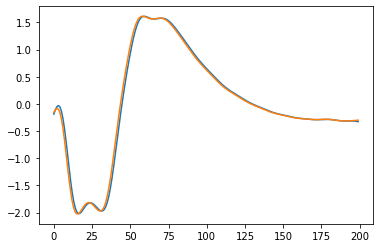

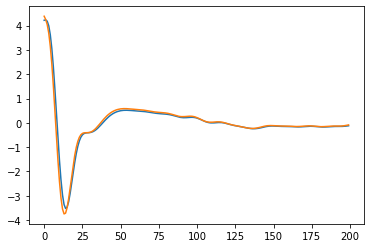

In [9]:
# plt.plot(train_labels)
# plt.show()
# plt.plot(test_labels)
# plt.show()

# plt.plot(seq_data[0])
# print(seq_labels[0])

# plt.ylim(-5, 5)
plt.plot(train_data[2000])
plt.plot(train_data[2001])
plt.show()

# plt.ylim(-5, 5)
plt.plot(test_data[2000])
plt.plot(test_data[2001])
plt.show()

Nothing (0)	165583	86.8318%
Left Wink (1)	8567	 4.4925%
Right Wink (2)	8566	 4.4920%
Dbl Blink (3)	7978	 4.1837%


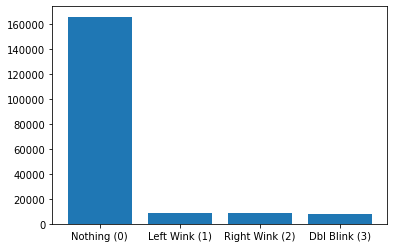

Nothing (0)	27529	86.7875%
Left Wink (1)	1451	 4.5744%
Right Wink (2)	1337	 4.2150%
Dbl Blink (3)	1403	 4.4231%


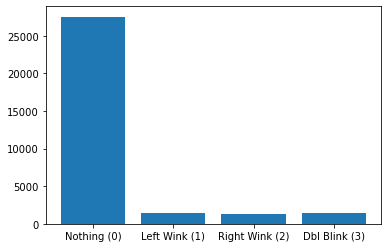

In [10]:
def labels_info(labels):
    # 0 for None, 1 for Left, 2 for Right
    bar_labels, bar_counts = np.unique(labels, return_counts=True)
    bar_labels = [f"{EVENT_ID_NAME_MAP[i]} ({i})" for i in bar_labels]

    for i,c in zip(bar_labels, bar_counts):
        print(f"{i}\t{c}\t{100*c/len(labels):7.4f}%")

    plt.bar(bar_labels, bar_counts)
    plt.show()

labels_info(train_labels)
labels_info(test_labels)

In [6]:
# BEST
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(.2, input_shape=(16,)),

    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dense(OUTPUT_SHAPE)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 13,972
Trainable params: 13,972
Non-trainable params: 0
_________________________________________________________________


In [103]:
# TEMP
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dropout(.25, input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2, input_shape=(64,)),

    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dense(OUTPUT_SHAPE)
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 200)               0         
                                                                 
 dropout_16 (Dropout)        (None, 200)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                12864     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 16)                1040      
                                                                 
 dense_42 (Dense)            (None, 4)                 68        
                                                                 
Total params: 13,972
Trainable params: 13,972
Non-tra

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 50

history = model.fit(
    train_data,
    train_labels,
    epochs=EPOCHS,
    validation_data=(test_data, test_labels)
#     batch_size=16
)

Epoch 1/50
5960/5960 [==============================] - 6s 950us/step - loss: 0.2102 - accuracy: 0.9279 - val_loss: 0.1592 - val_accuracy: 0.9377
Epoch 2/50
5960/5960 [==============================] - 6s 948us/step - loss: 0.1564 - accuracy: 0.9430 - val_loss: 0.1520 - val_accuracy: 0.9426
Epoch 3/50
5960/5960 [==============================] - 6s 929us/step - loss: 0.1424 - accuracy: 0.9471 - val_loss: 0.1540 - val_accuracy: 0.9420
Epoch 4/50
5960/5960 [==============================] - 6s 926us/step - loss: 0.1368 - accuracy: 0.9492 - val_loss: 0.1646 - val_accuracy: 0.9401
Epoch 5/50
5960/5960 [==============================] - 6s 934us/step - loss: 0.1320 - accuracy: 0.9501 - val_loss: 0.1369 - val_accuracy: 0.9461
Epoch 6/50
5960/5960 [==============================] - 5s 919us/step - loss: 0.1281 - accuracy: 0.9513 - val_loss: 0.1444 - val_accuracy: 0.9462
Epoch 7/50
5960/5960 [==============================] - 6s 926us/step - loss: 0.1263 - accuracy: 0.9519 - val_loss: 0.1573 -

In [16]:
plt.plot(history.history['accuracy'], label='Training acc', color="red")
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Training and validation accuracy')
# plt.ylim(0.8)
plt.legend()

NameError: name 'history' is not defined

In [123]:
test_loss, test_acc = model.evaluate(
    test_data,
    test_labels,
    verbose=2
)

print('\nTest accuracy:', test_acc)

2332/2332 - 2s - loss: 0.1672 - accuracy: 0.9500 - 2s/epoch - 701us/step

Test accuracy: 0.9500094056129456


In [6]:
def confusion_matrix_ml(data, labels):
    model_probs = model.predict(data)
    preds = tf.nn.softmax(model_probs, axis=1)
    # print(predictions)

    event_pred = np.argmax(preds, axis=1)
    # print(event_pred)

    return confusion_matrix(event_pred, labels)

def confusion_matrix_ml_models(model ,data, labels):
    model_probs = model.predict(data)
    preds = tf.nn.softmax(model_probs, axis=1)
    # print(predictions)

    event_pred = np.argmax(preds, axis=1)
    # print(event_pred)

    return confusion_matrix(event_pred, labels)


def confusion_matrix(label_pred, label_true):
    # Rows are "real" labels
    # Columns are "predicted" labels
    conf = tf.math.confusion_matrix(
        label_pred,
        label_true
    )
    
    return conf

def print_confusion_matrix(conf):
    print(conf)
    
    overall_total = sum(sum(conf))
    overall_correct = sum([conf[i][i] for i in range(len(conf))])
    print(f"Overall accuracy: {100*overall_correct/overall_total:.2f}% ({overall_correct}/{overall_total})")
    
    fp = sum(conf[0][1:])
    tp = sum(sum(conf[1:]))
    print(f"False positives {fp}")
    print(f"True positives {tp}")
    print(f"False discovery (fp/(tp+fp)): {fp/(fp+tp):.4f} ({fp}/{fp+tp})")
    
    for i in range(len(conf)):
        letter = str(EVENT_ID_LETTER_MAP[i])[0]
        
        total = sum(conf[i])
        correct = conf[i][i]
        acc_total = 100*correct/total
        
        s = f"Event {letter} ({i}) accuracy: {correct:6}/{total: <6} (t_acc {acc_total:5.2f}%)"
        if i > 0:
            acc_event = 100*correct/(total - conf[i][0])
            s += f" (e_acc {acc_event:5.2f}%)"
        print(s)
        
    return conf


In [ ]:
conf_mat = confusion_matrix_ml(model, train_data, train_labels)
print_confusion_matrix(conf_mat)
print("")
conf_mat = confusion_matrix_ml(model, test_data, test_labels)
print_confusion_matrix(conf_mat)

In [62]:
predictions = model.predict(test_data)
predictions = tf.nn.softmax(predictions, axis=1)

pred_none = np.array([i[0] for i in predictions])
pred_left = np.array([i[1] for i in predictions])
pred_right = np.array([i[2] for i in predictions])
pred_select  = np.array([i[3] for i in predictions])

print(pred_none)
print(pred_left)
print(pred_right)
print(pred_select)



[0.9999865  0.9999739  0.9999417  ... 0.999907   0.99988604 0.999859  ]
[1.2509793e-07 8.7020226e-08 3.2994532e-08 ... 1.2062196e-07 8.5842188e-08
 8.8265374e-08]
[8.6180911e-08 7.0341173e-07 1.2835714e-05 ... 2.1492509e-05 2.3121251e-05
 2.9841774e-05]
[1.3267131e-05 2.5278259e-05 4.5497753e-05 ... 7.1334427e-05 9.0755530e-05
 1.1108171e-04]


In [63]:
event_pred = np.argmax(predictions, axis=1)
print(event_pred)

[0 0 0 ... 0 0 0]


In [8]:
DOWNSAMPLE_PRED = 3

pred_ma = np.array(predictions)
print(len(pred_ma), pred_ma)

# pred_ma = pred_ma[:len(pred_ma) - (len(pred_ma)%DOWNSAMPLE_PRED)]
# pred_ma = np.mean(pred_ma.reshape(-1,DOWNSAMPLE_PRED,4), 1)
# print(len(pred_ma), pred_ma)

event_pred = np.argmax(pred_ma, axis=1)
print(event_pred)

event_sel_high = (pred_select > 0.2)
event_pred &= np.invert(event_sel_high)
event_pred |= event_sel_high * 3



NameError: name 'predictions' is not defined

In [64]:
# Plot the predictions alongside the actual ranges
# Looks to be 100% correct at least when deciding Left VS Right
# Mostly just the borders which are wrong (so not really an issue)

# Should add additional check which uses the output of this neural network itself as a feature.
# eg. The ANN needs to output "Left" or "Right" for 90% (or 50%?) of a sequence 0.1 seconds long.
def plot_prediction_probabilities(xlim_lower, xlim_upper):
    plt.figure(figsize=(14, 3), dpi=80)

    plt.plot(pred_none,  color=EVENT_COLOR_MAP[None], label=EVENT_ID_NAME_MAP[0])
    plt.plot(pred_left,  color=EVENT_COLOR_MAP["L"],  label=EVENT_ID_NAME_MAP[1])
    plt.plot(pred_right, color=EVENT_COLOR_MAP["R"],  label=EVENT_ID_NAME_MAP[2])
    plt.plot(pred_select, color=EVENT_COLOR_MAP["S"],  label=EVENT_ID_NAME_MAP[3])

    plt.xlim(xlim_lower, xlim_upper)
    plt.title("Model predicted probabilities")
    plt.legend()

    plt.show()

In [65]:
# True events
def plot_true_events(xlim_lower, xlim_upper):
    plt.figure(figsize=(14, 1), dpi=80)
    for i in range(4):
        x = np.array(range(len(test_labels)))[test_labels == i]
        y = test_labels[test_labels == i]/10
        plt.scatter(x, y, color=EVENT_COLOR_MAP[EVENT_ID_LETTER_MAP[i]], s=5)

    plt.xlim(xlim_lower, xlim_upper)
    plt.title("True events")
    plt.show()

In [66]:
# Final event predictions
def plot_pred_events(xlim_lower, xlim_upper):
    # Final preds
    plt.figure(figsize=(14, 1), dpi=80)
    for i in range(4):
        x = np.array(range(len(event_pred)))[event_pred == i]
        y = event_pred[event_pred == i]/10
        plt.scatter(x, y, color=EVENT_COLOR_MAP[EVENT_ID_LETTER_MAP[i]], s=5)

    plt.xlim(xlim_lower, xlim_upper)
    plt.title("Predicted events")
    plt.show()

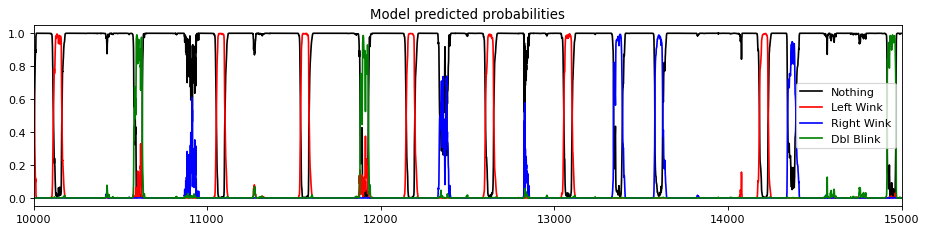

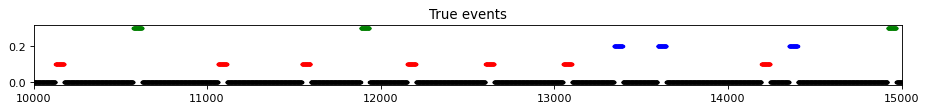

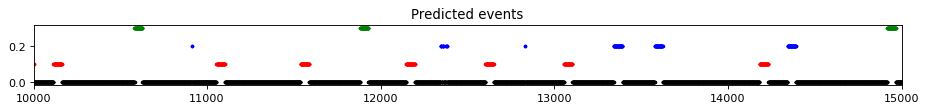

In [67]:
xlim_lower = 10000
xlim_upper = 15000

plot_prediction_probabilities(xlim_lower, xlim_upper)
plot_true_events(xlim_lower, xlim_upper)
plot_pred_events(xlim_lower, xlim_upper)

<Figure size 1120x160 with 0 Axes>

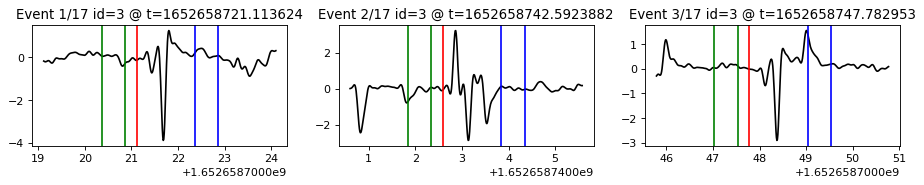

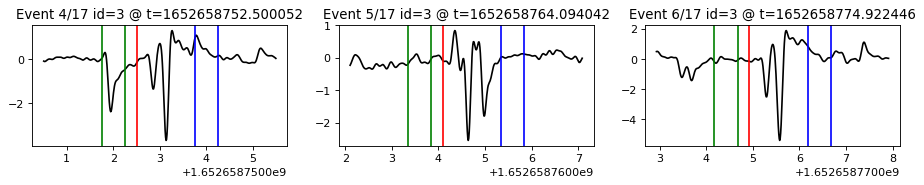

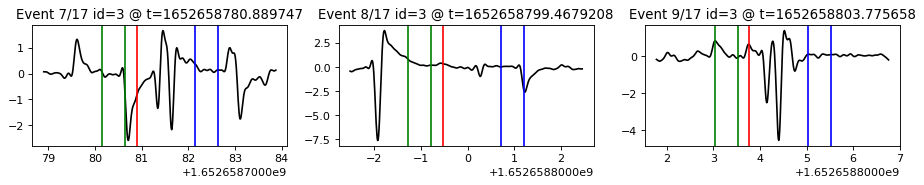

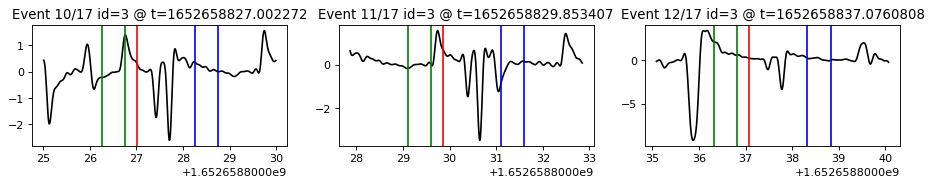

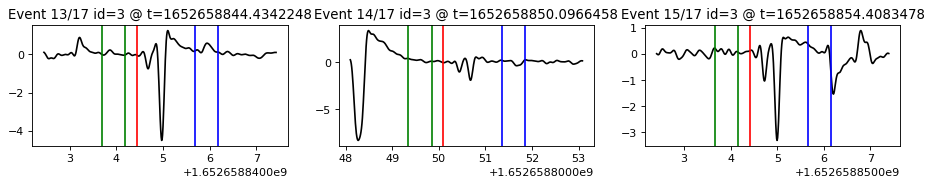

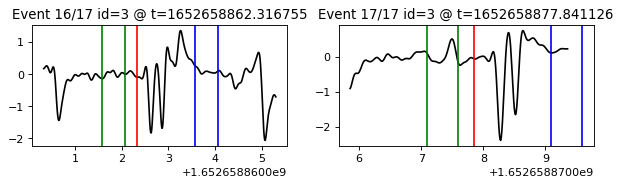

In [16]:
from data_load import load_sample_data, load_event_data, downsample
from data_transform import LP_Filter

# PLOT_FILE_NAME = FILE_NAMES_TRAIN[0]
# PLOT_FILE_NAME = FILE_NAMES_TEST[0]

# PLOT_FILE_NAME = "DATA_2022-05-12_Josh_0001_0_1652333343"

# PLOT_FILE_NAME = "DATA_2022-05-13_Josh_0001_3_1652400625"
# PLOT_FILE_NAME = "DATA_2022-05-13_Josh_0001_3_1652400939"
# PLOT_FILE_NAME = "DATA_2022-05-13_Josh_0001_4_1652401267"
PLOT_FILE_NAME = "DATA_2022-05-16_Marcus_0005_1_1652664616"

PLOT_FILE_NAME = FILE_NAMES_TRAIN[-2]


samples_df = load_sample_data(SAMPLES_PATH + PLOT_FILE_NAME)
samples_df["sample"] = LP_Filter(samples_df["sample"], cutOff=7)
samples_df = downsample(samples_df, n=DOWNSAMPLE_RATE)

events_df = load_event_data(
    file_path = EVENTS_PATH + PLOT_FILE_NAME,
    event_id_map = EVENT_ID_MAP,
    event_color_map = EVENT_COLOR_MAP,
)

plot_samples_events_individual(
    samples_df, events_df, 
    event_id = 3,
    
    event_length = EVENT_LENGTH,
    event_start = EVENT_START,
    event_end = EVENT_END,
    
    event_sample_count = 500,
    event_sample_offset = -200,
)

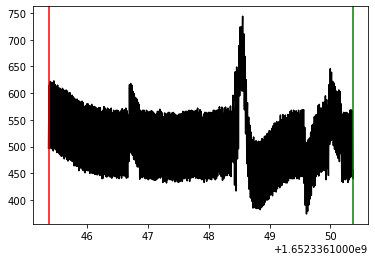

In [17]:
# PLOT_FILE_NAME = FILE_NAMES_TRAIN[2]
PLOT_FILE_NAME = FILE_NAMES_TEST[1]

samples_df = load_sample_data(SAMPLES_PATH + PLOT_FILE_NAME)
# samples_df = downsample(samples_df, n=DOWNSAMPLE_RATE)

ts = 1652336145.37
te = ts + 5
sint_df = samples_df[(samples_df["time_sec"] >= ts) & (samples_df["time_sec"] <= te)]

plt.plot(sint_df["time_sec"], sint_df["sample"], color="black")
plt.axvline(x=ts, color="red")
plt.axvline(x=te, color="green")
plt.show()

In [8]:
# PLOT_FILE_NAME = FILE_NAMES_TRAIN[2]
PLOT_FILE_NAME = FILE_NAMES_TEST[1]

samples_df = load_sample_data(SAMPLES_PATH + PLOT_FILE_NAME)
samples_df = downsample(samples_df, n=DOWNSAMPLE_RATE)

ts = 1652336145.37
te = t + 1
sint_df = samples_df[(samples_df["time_sec"] >= ts) & (samples_df["time_sec"] <= te)]

plt.plot(sint_df["time_sec"], sint_df["sample"], color="black")
plt.axvline(x=t, color="red")
plt.show()

NameError: name 't' is not defined

In [125]:
model.save("models/model_3_NoneReduce100.h5")

## Training Results

In [ ]:
30 epochs
50 might work too?

Epoch 30/30
4620/4620 [==============================] - 5s 1ms/step - 
loss: 0.1053 - accuracy: 0.9573 - val_loss: 0.1612 - val_accuracy: 0.9509
           
        
tf.Tensor(
[[126279    642    893    466]
 [   948   5485      0     28]
 [   725      0   6119     52]
 [   676      0     23   5484]], shape=(4, 4), dtype=int32)
Event N (0) accuracy: 126279/128280 (t_acc 98.44%)
Event L (1) accuracy:   5485/6461   (t_acc 84.89%) (e_acc 99.49%)
Event R (2) accuracy:   6119/6896   (t_acc 88.73%) (e_acc 99.16%)
Event S (3) accuracy:   5484/6183   (t_acc 88.69%) (e_acc 99.58%)

tf.Tensor(
[[63277   538   551   468]
 [  566  2989     0     0]
 [  410     0  2596     1]
 [  986     9   134  2069]], shape=(4, 4), dtype=int32)
Event N (0) accuracy:  63277/64834  (t_acc 97.60%)
Event L (1) accuracy:   2989/3555   (t_acc 84.08%) (e_acc 100.00%)
Event R (2) accuracy:   2596/3007   (t_acc 86.33%) (e_acc 99.96%)
Event S (3) accuracy:   2069/3198   (t_acc 64.70%) (e_acc 93.54%)
    
    
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(.2, input_shape=(16,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SHAPE)
])
    

FILE_NAMES_TRAIN = [
#     "DATA_2022-05-12_Josh_0001_0_1652333343",
#     "DATA_2022-05-12_Josh_0001_0_1652333800",
#     "DATA_2022-05-12_Josh_0001_1_1652334198",
#     "DATA_2022-05-12_Josh_0001_1_1652334982",
#     "DATA_2022-05-12_Josh_0001_2_1652335485",
#     "DATA_2022-05-12_Josh_0001_2_1652336009",
    
    "DATA_2022-05-13_Josh_0001_3_1652400625",
    "DATA_2022-05-13_Josh_0001_3_1652400939",
#     "DATA_2022-05-13_Josh_0001_4_1652401267",
#     "DATA_2022-05-13_Josh_0001_4_1652401740",
    "DATA_2022-05-13_Josh_0001_5_1652405337",
    "DATA_2022-05-13_Josh_0001_5_1652405637",
    "DATA_2022-05-13_Josh_0001_6_1652406023",
    "DATA_2022-05-13_Josh_0001_6_1652406202",
#     "DATA_2022-05-13_Josh_0001_7_1652406589",
#     "DATA_2022-05-13_Josh_0001_7_1652406788",
    "DATA_2022-05-13_Josh_0001_8_1652407331",
    "DATA_2022-05-13_Josh_0001_8_1652407508",
]

FILE_NAMES_TEST = [
#     "DATA_2022-05-12_Josh_0001_0_1652333343",
#     "DATA_2022-05-12_Josh_0001_0_1652333800",
#     "DATA_2022-05-12_Josh_0001_1_1652334198",
#     "DATA_2022-05-12_Josh_0001_1_1652334982",
#     "DATA_2022-05-12_Josh_0001_2_1652335485",
#     "DATA_2022-05-12_Josh_0001_2_1652336009",
    
#     "DATA_2022-05-13_Josh_0001_3_1652400625",
#     "DATA_2022-05-13_Josh_0001_3_1652400939",
    "DATA_2022-05-13_Josh_0001_4_1652401267",
    "DATA_2022-05-13_Josh_0001_4_1652401740",
#     "DATA_2022-05-13_Josh_0001_5_1652405337",
#     "DATA_2022-05-13_Josh_0001_5_1652405637",
#     "DATA_2022-05-13_Josh_0001_6_1652406023",
#     "DATA_2022-05-13_Josh_0001_6_1652406202",
    "DATA_2022-05-13_Josh_0001_7_1652406589",
    "DATA_2022-05-13_Josh_0001_7_1652406788",
#     "DATA_2022-05-13_Josh_0001_8_1652407331",
#     "DATA_2022-05-13_Josh_0001_8_1652407508",
]

EVENT_LENGTH = 2 # length of a given event sequence in seconds
EVENT_START = -0.75
EVENT_END = -0.25


NONE_EVENT = 1.00

## Cross Validation

In [19]:
FILE_NAMES_ALL = [
    "DATA_2022-05-13_Josh_0001_3_1652400625",
    "DATA_2022-05-13_Josh_0001_3_1652400939",
    "DATA_2022-05-13_Josh_0001_4_1652401267",
    "DATA_2022-05-13_Josh_0001_4_1652401740",
    "DATA_2022-05-13_Josh_0001_5_1652405337",
    "DATA_2022-05-13_Josh_0001_5_1652405637",
    "DATA_2022-05-13_Josh_0001_6_1652406023",
    "DATA_2022-05-13_Josh_0001_6_1652406202",
    "DATA_2022-05-13_Josh_0001_7_1652406589",
    "DATA_2022-05-13_Josh_0001_7_1652406788",
    "DATA_2022-05-13_Josh_0001_8_1652407331",
    "DATA_2022-05-13_Josh_0001_8_1652407508",
]

CV_K = len(FILE_NAMES_ALL)
# CV_K = 4

print(f"{CV_K}-fold CV")

CV_EPOCHS = 50


12-fold CV


In [9]:
def cv_get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
        tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_SHAPE)
    ])
#     model.summary()
    return model

In [10]:
def cv_get_data():
    print("Loading training data")
    train_data_all, train_labels_all = get_ml_data(
        events_path = EVENTS_PATH,
        samples_path = SAMPLES_PATH,
        file_names = FILE_NAMES_TRAIN,

        event_id_map = EVENT_ID_MAP,
        event_color_map = EVENT_COLOR_MAP,

        event_sample_count = EVENT_SAMPLE_COUNT,
        event_start = EVENT_START,
        event_end = EVENT_END,

        downsample_rate = DOWNSAMPLE_RATE,
        shuffle_data = False,
        filter_data = True,
    )
    
    print("Loading test data")
    test_data, test_labels = get_ml_data(
        events_path = EVENTS_PATH,
        samples_path = SAMPLES_PATH,
        file_names = FILE_NAMES_TEST,

        event_id_map = EVENT_ID_MAP,
        event_color_map = EVENT_COLOR_MAP,

        event_sample_count = EVENT_SAMPLE_COUNT,
        event_start = EVENT_START,
        event_end = EVENT_END,

        downsample_rate = DOWNSAMPLE_RATE,
        shuffle_data = False,
        filter_data = True,
    )


    NONE_PROPORTION = 1.00
    # NONE_PROPORTION = 0.50
    # NONE_PROPORTION = 0.25

    train_filter = (train_labels_all != 0) | (np.random.random(len(train_labels_all)) <= NONE_PROPORTION)
    train_data = train_data_all[train_filter]
    train_labels = train_labels_all[train_filter]

    # train_data = train_data_all
    # train_labels = train_labels_all

    print(train_data.shape, train_data)
    print(train_labels.shape, train_labels)
    
    return (train_data, train_labels, test_data, test_labels)



In [11]:
def cv_train_model(model, train_data, train_labels, test_data, test_labels):
    # Trains model and returns history dict
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = model.fit(
        train_data,
        train_labels,
        epochs=CV_EPOCHS,
        validation_data=(test_data, test_labels)
    #     batch_size=16
    )
    
    return history


In [23]:
cv_models = []
cv_history = []
cv_test_loss = []
cv_test_acc = []
cv_conf_mat = []


for i in range(CV_K):
    print(f"Fold #{i+1}/{CV_K}")
    start_time = time.time()
    
    FILE_NAMES_TRAIN = FILE_NAMES_ALL[0:i] + FILE_NAMES_ALL[i+1:]
    FILE_NAMES_TEST = [FILE_NAMES_ALL[i]]
    print(FILE_NAMES_TRAIN, FILE_NAMES_TEST)
    
    model = cv_get_model()
    
    train_data, train_labels, test_data, test_labels = cv_get_data()

    # Train model
    history = cv_train_model(model, train_data, train_labels, test_data, test_labels)
    
    # Test loss
    test_loss, test_acc = model.evaluate(
        test_data,
        test_labels,
        verbose=2
    )
    print('\nTest accuracy:', test_acc)
    
    # Conf mat
    conf_mat = confusion_matrix_ml(model, test_data, test_labels)
    print_confusion_matrix(conf_mat)
    cv_conf_mat.append(conf_mat)
    
    cv_models.append(model)
    cv_history.append(history)
    cv_test_loss.append(test_loss)
    cv_test_acc.append(test_acc)
    
    
    plt.plot(history.history['accuracy'], label='Training acc', color="red")
    plt.plot(history.history['val_accuracy'], label='Validation acc')
    plt.title('Training and validation accuracy')
    # plt.ylim(0.8)
    plt.legend()
    plt.show()
    
    print(f"Done fold in {time.time() - start_time:.2f}s")
    

print("DONE CV")

Fold #1/12
['DATA_2022-05-13_Josh_0001_3_1652400939', 'DATA_2022-05-13_Josh_0001_4_1652401267', 'DATA_2022-05-13_Josh_0001_4_1652401740', 'DATA_2022-05-13_Josh_0001_5_1652405337', 'DATA_2022-05-13_Josh_0001_5_1652405637', 'DATA_2022-05-13_Josh_0001_6_1652406023', 'DATA_2022-05-13_Josh_0001_6_1652406202', 'DATA_2022-05-13_Josh_0001_7_1652406589', 'DATA_2022-05-13_Josh_0001_7_1652406788', 'DATA_2022-05-13_Josh_0001_8_1652407331', 'DATA_2022-05-13_Josh_0001_8_1652407508'] ['DATA_2022-05-13_Josh_0001_3_1652400625']
Loading training data
Loading ML data from 11 files

Transforming data into individual sequences...
Transformed into 16552 sequences of size 200

Transforming data into individual sequences...
Transformed into 21609 sequences of size 200

Transforming data into individual sequences...
Transformed into 17151 sequences of size 200

Transforming data into individual sequences...
Transformed into 24467 sequences of size 200

Transforming data into individual sequences...
Transformed

Epoch 41/50
6356/6356 [==============================] - 6s 904us/step - loss: 0.1124 - accuracy: 0.9565 - val_loss: 0.0982 - val_accuracy: 0.9615
Epoch 42/50
6356/6356 [==============================] - 6s 906us/step - loss: 0.1113 - accuracy: 0.9563 - val_loss: 0.0935 - val_accuracy: 0.9642
Epoch 43/50
6356/6356 [==============================] - 6s 904us/step - loss: 0.1114 - accuracy: 0.9562 - val_loss: 0.0909 - val_accuracy: 0.9644
Epoch 44/50
6356/6356 [==============================] - 6s 902us/step - loss: 0.1116 - accuracy: 0.9566 - val_loss: 0.0992 - val_accuracy: 0.9611
Epoch 45/50
6356/6356 [==============================] - 6s 919us/step - loss: 0.1112 - accuracy: 0.9568 - val_loss: 0.0937 - val_accuracy: 0.9607
Epoch 46/50
6356/6356 [==============================] - 6s 901us/step - loss: 0.1111 - accuracy: 0.9567 - val_loss: 0.0954 - val_accuracy: 0.9616
Epoch 47/50
6356/6356 [==============================] - 6s 904us/step - loss: 0.1117 - accuracy: 0.9561 - val_loss: 0

NameError: name 'confusion_matrix_ml' is not defined

[<keras.engine.sequential.Sequential object at 0x7f3387035030>, <keras.engine.sequential.Sequential object at 0x7f329eded9f0>, <keras.engine.sequential.Sequential object at 0x7f33873da9e0>, <keras.engine.sequential.Sequential object at 0x7f33870ef7c0>, <keras.engine.sequential.Sequential object at 0x7f33871a1390>, <keras.engine.sequential.Sequential object at 0x7f32a2e83700>, <keras.engine.sequential.Sequential object at 0x7f329f8c2770>, <keras.engine.sequential.Sequential object at 0x7f329f985450>, <keras.engine.sequential.Sequential object at 0x7f33871a0550>, <keras.engine.sequential.Sequential object at 0x7f32975d7e20>, <keras.engine.sequential.Sequential object at 0x7f32a3512ad0>, <keras.engine.sequential.Sequential object at 0x7f32a29c83a0>]
[<keras.callbacks.History object at 0x7f338e5e2770>, <keras.callbacks.History object at 0x7f32974c8400>, <keras.callbacks.History object at 0x7f338722e950>, <keras.callbacks.History object at 0x7f32974c94b0>, <keras.callbacks.History object at

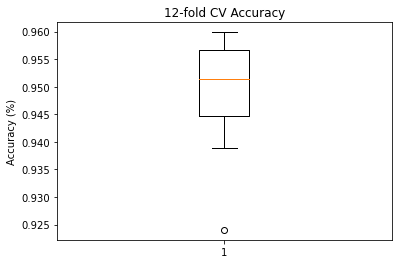

tf.Tensor(
[[188216   1979   1577   1340]
 [  1434   8503      0     81]
 [  1404      5   8354    140]
 [  2816    110    272   6183]], shape=(4, 4), dtype=int32)
Event N (0) accuracy: 188216/193112 (t_acc 97.46%)
Event L (1) accuracy:   8503/10018  (t_acc 84.88%) (e_acc 99.06%)
Event R (2) accuracy:   8354/9903   (t_acc 84.36%) (e_acc 98.29%)
Event S (3) accuracy:   6183/9381   (t_acc 65.91%) (e_acc 94.18%)


<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[188216,   1979,   1577,   1340],
       [  1434,   8503,      0,     81],
       [  1404,      5,   8354,    140],
       [  2816,    110,    272,   6183]], dtype=int32)>

In [85]:
print(cv_models)
print(cv_history)
print(cv_test_loss)
print(cv_test_acc)



plt.boxplot(cv_test_acc)
print("Mean test acc", np.mean(cv_test_acc))
# plt.legend()
# plt.xlabel("Epoch")
plt.title(f"{CV_K}-fold CV Accuracy")
plt.ylabel("Accuracy (%)")
plt.show()



cv_conf_mat_full = sum(cv_conf_mat)
print_confusion_matrix(cv_conf_mat_full)




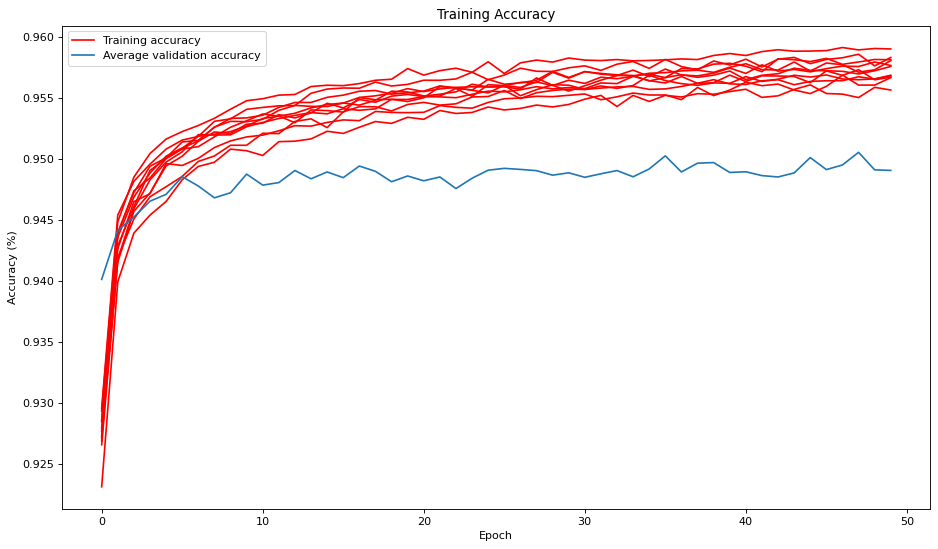

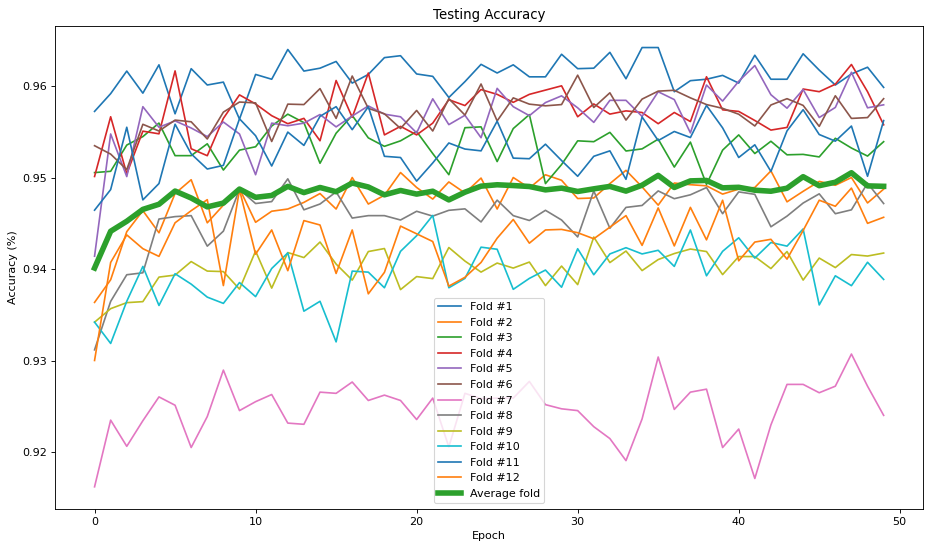

In [84]:
mean_val_acc = np.mean([history.history['val_accuracy'] for history in cv_history], axis=0)

# # plt.figure(figsize=(14, 8), dpi=80)
# for history in cv_history:
#     plt.plot(history.history['accuracy'], label='Training acc', color="red")
#     plt.plot(history.history['val_accuracy'], label='Validation acc')

# plt.title('Training and validation accuracy')
# # plt.ylim(0.8)
# plt.legend()
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy (%)")
# plt.show()


plt.figure(figsize=(14, 8), dpi=80)
for i,history in enumerate(cv_history[1:]):
#     plt.plot(history.history['accuracy'], label=f'Fold #{i+1}')
    plt.plot(history.history['accuracy'], color="red", label=None if i>0 else "Training accuracy")

plt.plot(mean_val_acc, label=f'Average validation accuracy')

plt.title('Training Accuracy')
# plt.ylim(0.8)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()



plt.figure(figsize=(14, 8), dpi=80)

for i,history in enumerate(cv_history):
    plt.plot(history.history['val_accuracy'], label=f'Fold #{i+1}')
    
plt.plot(mean_val_acc, label=f'Average fold', linewidth=5)
    
plt.title('Testing Accuracy')
# plt.ylim(0.8)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()





In [88]:
# CV_COMBINED = {}
# CV_COMBINED

In [86]:
CV_COMBINED["2"] = {
    "cv_models": cv_models,
    "cv_history": cv_history,
    "cv_test_loss": cv_test_loss,
    "cv_test_acc": cv_test_acc,
    "cv_conf_mat": cv_conf_mat,
}

In [44]:
print(train_data.shape, train_data)
print(train_labels.shape, train_labels)
print(test_data.shape, test_data)
print(test_labels.shape, test_labels)

(190694, 200) [[ 0.04446229  0.01575258 -0.00969483 ... -1.43863004 -1.49974307
  -1.5609112 ]
 [-0.3765672  -0.28010472 -0.18866591 ... -1.3281225  -1.29381709
  -1.25417322]
 [ 0.15950153  0.11269629  0.07044077 ... -1.46019454 -1.48492949
  -1.51023276]
 ...
 [-0.23311691 -0.22080598 -0.20843852 ...  0.50895407  0.49014028
   0.47136286]
 [-0.2260185  -0.21244389 -0.19894283 ...  0.40567544  0.3512771
   0.2946881 ]
 [-0.20011873 -0.19159844 -0.18279468 ...  0.44778575  0.44207815
   0.4378377 ]]
(190694,) [0 0 0 ... 0 0 0]
(31720, 200) [[-0.17562989 -0.16171338 -0.14595547 ...  0.84773072  0.78127583
   0.7153172 ]
 [-0.09114919 -0.09471166 -0.09480827 ...  0.76951904  0.6987726
   0.62785844]
 [-0.17346762 -0.14464314 -0.11454972 ...  0.7383057   0.68908425
   0.64056263]
 ...
 [-0.58468988 -0.95153513 -1.28465347 ...  0.21811694  0.1436895
   0.06513735]
 [-1.4270924  -1.54523546 -1.64565642 ...  0.32360414  0.32602305
   0.33016155]
 [-1.85433934 -1.82211735 -1.78318912 ...  0.1

In [13]:
from sklearn import svm
X = train_data[:30000]
y = train_labels[:30000]

print(y)
start_time = time.time()
# X = [[0, 0], [1, 1]]
# y = [0, 1]
clf = svm.SVC()
clf.fit(X, y)

#For Quantitative Evaluation
svm_clf = clf
print("Training done", time.time() - start_time)
# 30k -> 20s
# 40k -> 40s
# 50k -> 70s

[0 0 0 ... 0 0 0]
Training done 23.17774271965027


In [15]:
start_time = time.time()

preds = clf.predict(test_data[:1000])
print(preds)

# Conf mat
conf_mat = confusion_matrix(preds, test_labels[:1000])
print_confusion_matrix(conf_mat)

print("Testing done", time.time() - start_time)

# 30k -> 47s



# tf.Tensor(
# [[188216   1979   1577   1340]
#  [  1434   8503      0     81]
#  [  1404      5   8354    140]
#  [  2816    110    272   6183]], shape=(4, 4), dtype=int32)
# Event N (0) accuracy: 188216/193112 (t_acc 97.46%)
# Event L (1) accuracy:   8503/10018  (t_acc 84.88%) (e_acc 99.06%)
# Event R (2) accuracy:   8354/9903   (t_acc 84.36%) (e_acc 98.29%)
# Event S (3) accuracy:   6183/9381   (t_acc 65.91%) (e_acc 94.18%)

tf.Tensor(
[[189976   1968   1853   4519]
 [  1277   7982      0     75]
 [  1320      0   8018     85]
 [   539     68     32   4702]], shape=(4, 4), dtype=int32)
Overall accuracy: 94.72% (210678/222414)
Event N (0) accuracy: 189976/198316 (t_acc 95.79%)
Event L (1) accuracy:   7982/9334   (t_acc 85.52%) (e_acc 99.07%)
Event R (2) accuracy:   8018/9423   (t_acc 85.09%) (e_acc 98.95%)
Event S (3) accuracy:   4702/5341   (t_acc 88.04%) (e_acc 97.92%)

SyntaxError: invalid syntax (Temp/ipykernel_17512/190065165.py, line 27)

In [26]:
def cv_get_model_svm():
    from sklearn import svm
    clf = svm.SVC()
    return clf

In [27]:
def cv_train_model_svm(model, train_data, train_labels, test_data, test_labels):
    start_time = time.time()
    subset = np.random.random(len(train_data)) < 0.1
    print("Training SVM with", sum(subset))
    model.fit(train_data[subset], train_labels[subset])
    print("Training done", time.time() - start_time)

In [18]:
FILE_NAMES_ALL = [
    "DATA_2022-05-13_Josh_0001_3_1652400625",
    "DATA_2022-05-13_Josh_0001_3_1652400939",
    "DATA_2022-05-13_Josh_0001_4_1652401267",
    "DATA_2022-05-13_Josh_0001_4_1652401740",
    "DATA_2022-05-13_Josh_0001_5_1652405337",
    "DATA_2022-05-13_Josh_0001_5_1652405637",
    "DATA_2022-05-13_Josh_0001_6_1652406023",
    "DATA_2022-05-13_Josh_0001_6_1652406202",
    "DATA_2022-05-13_Josh_0001_7_1652406589",
    "DATA_2022-05-13_Josh_0001_7_1652406788",
    "DATA_2022-05-13_Josh_0001_8_1652407331",
    "DATA_2022-05-13_Josh_0001_8_1652407508",
]

CV_K = len(FILE_NAMES_ALL)
# CV_K = 4

print(f"{CV_K}-fold CV")


cv_svm_models = []
cv_svm_conf_mat = []

print("CV SVM")


for i in range(CV_K):
    print(f"Fold #{i+1}/{CV_K}")
    start_time = time.time()
    
    FILE_NAMES_TRAIN = FILE_NAMES_ALL[0:i] + FILE_NAMES_ALL[i+1:]
    FILE_NAMES_TEST = [FILE_NAMES_ALL[i]]
    print(FILE_NAMES_TRAIN, FILE_NAMES_TEST)
    
    model = cv_get_model_svm()
    
    train_data, train_labels, test_data, test_labels = cv_get_data()

    # Train model
    history = cv_train_model_svm(model, train_data, train_labels, test_data, test_labels)
    
    preds = model.predict(test_data)
#     print(preds)

    # Conf mat
    conf_mat = confusion_matrix(preds, test_labels)
    print_confusion_matrix(conf_mat)

    cv_svm_models.append(model)
    cv_svm_conf_mat.append(conf_mat)
    
#     cv_history.append(history)
#     cv_test_loss.append(test_loss)
#     cv_test_acc.append(test_acc)
    
#     plt.plot(history.history['accuracy'], label='Training acc', color="red")
#     plt.plot(history.history['val_accuracy'], label='Validation acc')
#     plt.title('Training and validation accuracy')
#     # plt.ylim(0.8)
#     plt.legend()
#     plt.show()
    
    print(f"Done fold in {time.time() - start_time:.2f}s")
    
print("DONE CV")

12-fold CV
CV SVM
Fold #1/12
['DATA_2022-05-13_Josh_0001_3_1652400939', 'DATA_2022-05-13_Josh_0001_4_1652401267', 'DATA_2022-05-13_Josh_0001_4_1652401740', 'DATA_2022-05-13_Josh_0001_5_1652405337', 'DATA_2022-05-13_Josh_0001_5_1652405637', 'DATA_2022-05-13_Josh_0001_6_1652406023', 'DATA_2022-05-13_Josh_0001_6_1652406202', 'DATA_2022-05-13_Josh_0001_7_1652406589', 'DATA_2022-05-13_Josh_0001_7_1652406788', 'DATA_2022-05-13_Josh_0001_8_1652407331', 'DATA_2022-05-13_Josh_0001_8_1652407508'] ['DATA_2022-05-13_Josh_0001_3_1652400625']


NameError: name 'cv_get_data' is not defined

In [102]:


# plt.boxplot(cv_test_acc)
# print("Mean test acc", np.mean(cv_test_acc))
# # plt.legend()
# # plt.xlabel("Epoch")
# plt.title(f"{CV_K}-fold CV Accuracy")
# plt.ylabel("Accuracy (%)")
# plt.show()


cv_conf_mat_full = sum(cv_svm_conf_mat)
print_confusion_matrix(cv_conf_mat_full)



tf.Tensor(
[[189976   1968   1853   4519]
 [  1277   7982      0     75]
 [  1320      0   8018     85]
 [   539     68     32   4702]], shape=(4, 4), dtype=int32)
Overall accuracy: 94.72% (210678/222414)
False positives 8340
True positives 24098
False discovery (fp/(tp+fp)): 0.2571 (8340/32438)
Event N (0) accuracy: 189976/198316 (t_acc 95.79%)
Event L (1) accuracy:   7982/9334   (t_acc 85.52%) (e_acc 99.07%)
Event R (2) accuracy:   8018/9423   (t_acc 85.09%) (e_acc 98.95%)
Event S (3) accuracy:   4702/5341   (t_acc 88.04%) (e_acc 97.92%)


<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[189976,   1968,   1853,   4519],
       [  1277,   7982,      0,     75],
       [  1320,      0,   8018,     85],
       [   539,     68,     32,   4702]], dtype=int32)>

In [105]:

cv_conf_mat_full_ml = np.array([[188216,   1979,   1577,   1340],
       [  1434,   8503,      0,     81],
       [  1404,      5,   8354,    140],
       [  2816,    110,    272,   6183]])

print_confusion_matrix(cv_conf_mat_full_ml)



[[188216   1979   1577   1340]
 [  1434   8503      0     81]
 [  1404      5   8354    140]
 [  2816    110    272   6183]]
Overall accuracy: 94.98% (211256/222414)
False positives 4896
True positives 29302
False discovery (fp/(tp+fp)): 0.1432 (4896/34198)
Event N (0) accuracy: 188216/193112 (t_acc 97.46%)
Event L (1) accuracy:   8503/10018  (t_acc 84.88%) (e_acc 99.06%)
Event R (2) accuracy:   8354/9903   (t_acc 84.36%) (e_acc 98.29%)
Event S (3) accuracy:   6183/9381   (t_acc 65.91%) (e_acc 94.18%)


array([[188216,   1979,   1577,   1340],
       [  1434,   8503,      0,     81],
       [  1404,      5,   8354,    140],
       [  2816,    110,    272,   6183]])

In [ ]:
def cv_get_model_rf():
    from sklearn import svm
    clf = svm.SVC()
    return clf

In [ ]:
FILE_NAMES_ALL = [
    "DATA_2022-05-13_Josh_0001_3_1652400625",
    "DATA_2022-05-13_Josh_0001_3_1652400939",
    "DATA_2022-05-13_Josh_0001_4_1652401267",
    "DATA_2022-05-13_Josh_0001_4_1652401740",
    "DATA_2022-05-13_Josh_0001_5_1652405337",
    "DATA_2022-05-13_Josh_0001_5_1652405637",
    "DATA_2022-05-13_Josh_0001_6_1652406023",
    "DATA_2022-05-13_Josh_0001_6_1652406202",
    "DATA_2022-05-13_Josh_0001_7_1652406589",
    "DATA_2022-05-13_Josh_0001_7_1652406788",
    "DATA_2022-05-13_Josh_0001_8_1652407331",
    "DATA_2022-05-13_Josh_0001_8_1652407508",
]

CV_K = len(FILE_NAMES_ALL)
# CV_K = 4

print(f"{CV_K}-fold CV")


cv_svm_models = []
cv_svm_conf_mat = []

print("CV SVM")


for i in range(CV_K):
    print(f"Fold #{i+1}/{CV_K}")
    start_time = time.time()
    
    FILE_NAMES_TRAIN = FILE_NAMES_ALL[0:i] + FILE_NAMES_ALL[i+1:]
    FILE_NAMES_TEST = [FILE_NAMES_ALL[i]]
    print(FILE_NAMES_TRAIN, FILE_NAMES_TEST)
    
    model = cv_get_model_svm()
    
    train_data, train_labels, test_data, test_labels = cv_get_data()

    # Train model
    history = cv_train_model_svm(model, train_data, train_labels, test_data, test_labels)
    
    preds = model.predict(test_data)
#     print(preds)

    # Conf mat
    conf_mat = confusion_matrix(preds, test_labels)
    print_confusion_matrix(conf_mat)

    cv_svm_models.append(model)
    cv_svm_conf_mat.append(conf_mat)
    
#     cv_history.append(history)
#     cv_test_loss.append(test_loss)
#     cv_test_acc.append(test_acc)
    
#     plt.plot(history.history['accuracy'], label='Training acc', color="red")
#     plt.plot(history.history['val_accuracy'], label='Validation acc')
#     plt.title('Training and validation accuracy')
#     # plt.ylim(0.8)
#     plt.legend()
#     plt.show()
    
    print(f"Done fold in {time.time() - start_time:.2f}s")
    
print("DONE CV")

KeyError: 'names'

In [9]:
#XGBoosted Random Forest Classifier setup
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm
from xgboost import XGBRFClassifier
from matplotlib import pyplot

>10 0.984 (0.015)
>50 0.987 (0.011)
>100 0.990 (0.010)
>500 0.990 (0.010)
>1000 0.990 (0.011)
>5000 0.990 (0.011)


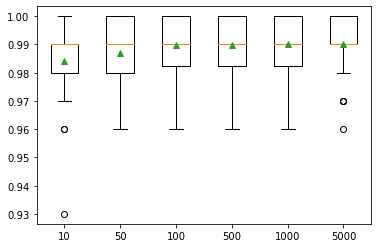

In [17]:
#Optimizing Number of Decision Trees

#Make multiple random forests with different number of decision trees
def make_variable_tree_models():
    models_dict = dict()
    
    #Number of Trees
    n_trees = [10, 50, 100, 500, 1000, 5000]
    
    for trees in n_trees:
        models_dict[str(trees)] = XGBRFClassifier(n_estimators=trees, subsample=0.9, colsample_bynode=0.2)
    
    return models_dict
 
# calculate model accuracy using cross-validation
def run_cv_on_model(model, X, y):
    # Defince CV conditions
    cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=1)
    
    # Calculate Accuracy
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return acc
 
# Setup Dataset
X, y = test_data[:1000], test_labels[:1000]

#Get multiple random forest models with different number of decision trees
randomForests = make_variable_tree_models()

# Run CV on all models and compare accuracies for varying number of trees
accuracies_all, num_trees_all = list(), list()

for num_trees, randomForest in randomForests.items():
    # Run CV and store returned accuracy
    accuracies = run_cv_on_model(randomForest, X, y)

    # Cache Accuracies and Number of Trees
    accuracies_all.append(accuracies)
    num_trees_all.append(num_trees)
    
    #Print Current num_trees and accuracy summaries
    print("{} {0.3f} ({0.3f})".format(num_trees, mean(accuracies), std(accuracies)))

# plot all accuracies to compare effect of changing number of trees
pyplot.boxplot(accuracies_all, labels=num_trees_all, showmeans=True)
pyplot.show()

>0.1 0.989 (0.010)
>0.2 0.990 (0.010)
>0.3 0.987 (0.011)
>0.4 0.986 (0.011)
>0.5 0.985 (0.012)
>0.6 0.982 (0.012)
>0.7 0.982 (0.013)
>0.8 0.978 (0.014)
>0.9 0.975 (0.015)
>1.0 0.974 (0.015)


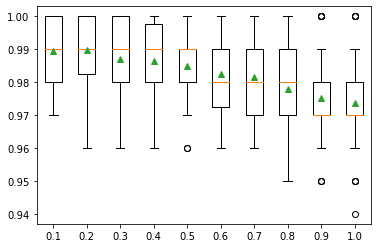

In [16]:
#Optimizing Number of Features

#Make multiple random forests with different number of features
def make_variable_features_models():
    
    models_dict = dict()
    
    for num_features in arange(0.1, 1.1, 0.1):
        num_features_key = '%.1f' % num_features
        models[num_features_key] = XGBRFClassifier(n_estimators=100, subsample=0.9, colsample_bynode=num_features)
    
    return models_dict
 
# calculate model accuracy using cross-validation
def run_cv_on_model(model, X, y):
    # Defince CV conditions
    cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=1)
    
    # Calculate Accuracy
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return acc
 
# Setup Dataset
X, y = test_data[:1000], test_labels[:1000]

#Get multiple random forest models with different number of features
randomForests = make_variable_features_models()

# Run CV on all models and compare accuracies for varying number of features
accuracies_all, num_features_all = list(), list()

for num_features, randomForest in randomForests.items():
    # Run CV and store returned accuracy
    accuracies = run_cv_on_model(randomForest, X, y)

    # Cache Accuracies and Number of features
    accuracies_all.append(accuracies)
    num_features_all.append(num_features)
    
    #Print Current num_features and accuracy summaries
    print("{} {0.3f} ({0.3f})".format(num_features, mean(accuracies), std(accuracies)))

# plot all accuracies to compare effect of changing number of features
pyplot.boxplot(accuracies_all, labels=num_features_all, showmeans=True)
pyplot.show()

In [10]:
# Classifiers for Quatitative Evaluation, trained on a subset of training data

train_data_subset = train_data[0:10000]
train_labels_subset = train_labels[0:10000]
print("training data has been split, building models now")

#SVM
svm_clf = svm.SVC()
svm_clf.fit(train_data_subset, train_labels_subset)
print("SVM has been trained for hold-out evaluation")

# XGB Random Forest
xgbrf_clf = XGBRFClassifier(n_estimators=5000, subsample=0.9, colsample_bynode=0.1).fit(train_data_subset, train_labels_subset)
print("XGBRandomForest has been trained for hold-out evaluation")


# ANN
ann_clf = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dense(OUTPUT_SHAPE)
])

ann_clf.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 50

ann_clf_history = ann_clf.fit(
          train_data_subset,
          train_labels_subset,
          epochs = EPOCHS,
          validation_data=(test_data, test_labels)
)
print("ANN has been trained for hold-out evaluation")



training data has been split, building models now
SVM has been trained for hold-out evaluation
XGBRandomForest has been trained for hold-out evaluation
Epoch 1/50
313/313 [==============================] - 1s 3ms/step - loss: 0.3526 - accuracy: 0.8717 - val_loss: 0.3224 - val_accuracy: 0.8825
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 0.1496 - accuracy: 0.9438 - val_loss: 0.3159 - val_accuracy: 0.8828
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 0.1109 - accuracy: 0.9561 - val_loss: 0.3201 - val_accuracy: 0.8903
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 0.0891 - accuracy: 0.9649 - val_loss: 0.3551 - val_accuracy: 0.8874
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 0.0787 - accuracy: 0.9709 - val_loss: 0.3470 - val_accuracy: 0.8939
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.0692 - accuracy: 0.9737 - val_loss: 0.3511 - val_accuracy: 0.9

In [12]:
#Quantitative Evaluation 1: Hold-out evaluation (No-resampling)

svm_predictions_holdout = svm_clf.predict(test_data[:1000])
print("SVM predictions complete")
xgbrf_predictions_holdout = xgbrf_clf.predict(test_data[:1000])
print("XGBRF predictions complete")

cnf_matrix_svm = confusion_matrix(svm_predictions_holdout, test_labels[:1000])
print("SVM confusion matrix generated")
cnf_matrix_xgbrf = confusion_matrix(xgbrf_predictions_holdout, test_labels[:1000])
print("XGBRF confusion matrix generated")
cnf_matrix_ann = confusion_matrix_ml_models(ann_clf, test_data[:1000], test_labels[:1000])
print("ANN confusion matrix generated")

print("------------------------------------------------")
print("Hold out evaluation confusion matrices are")
print("Confusion Matrix for SVM:")
print_confusion_matrix(cnf_matrix_svm)
print("------------------------------------------------")

print("Confusion Matrix for XGBRF:")
print_confusion_matrix(cnf_matrix_xgbrf)
print("------------------------------------------------")

print("Confusion Matrix for ANN:")
print_confusion_matrix(cnf_matrix_ann)
print("------------------------------------------------")

SVM predictions complete
XGBRF predictions complete
SVM confusion matrix generated
XGBRF confusion matrix generated
32/32 [==============================] - 0s 708us/step
ANN confusion matrix generated
------------------------------------------------
Hold out evaluation confusion matrices are
Confusion Matrix for SVM:
tf.Tensor(
[[879  10  50]
 [ 21  40   0]
 [  0   0   0]], shape=(3, 3), dtype=int32)
Overall accuracy: 91.90% (919/1000)
False positives 60
True positives 61
False discovery (fp/(tp+fp)): 0.4959 (60/121)
Event N (0) accuracy:    879/939    (t_acc 93.61%)
Event L (1) accuracy:     40/61     (t_acc 65.57%) (e_acc 100.00%)
Event R (2) accuracy:      0/0      (t_acc   nan%) (e_acc   nan%)
------------------------------------------------
Confusion Matrix for XGBRF:
tf.Tensor(
[[896  14  50]
 [  4  36   0]
 [  0   0   0]], shape=(3, 3), dtype=int32)
Overall accuracy: 93.20% (932/1000)
False positives 64
True positives 40
False discovery (fp/(tp+fp)): 0.6154 (64/104)
Event N (0)

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

seed = 7
np.random.seed(seed)

def ann_scikit_wrapped():
    model = Sequential()
    model.add(Flatten(input_shape=INPUT_SHAPE))
    model.add(Dropout(.25, input_shape=INPUT_SHAPE))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2, input_shape=(64,)))
    model.add(Dense(16, activation='relu'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model
    

ann_clf_wrapped = KerasClassifier(build_fn=ann_scikit_wrapped, epochs=50, batch_size = 32, verbose=0)

C:\Users\atew5032\AppData\Local\Temp/ipykernel_14860/353599147.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_clf_wrapped = KerasClassifier(build_fn=ann_scikit_wrapped, epochs=50, batch_size = 32, verbose=0)


In [50]:
#Quantitative Evaluation 2: Stratified K-Fold cross validation (simple-resampling)
from sklearn.model_selection import StratifiedKFold


sfk = StratifiedKFold(n_splits = 5)

print("Starting Stratified 5 fold cross validation on SVM")
svm_sfk_score = cross_val_score(svm_clf, train_data_subset, 
                                train_labels_subset,
                               scoring='accuracy',
                               cv=sfk,
                               n_jobs=-1)

print("Starting Stratified 5 fold cross validation on XGBRF")
xgbrf_sfk_score = cross_val_score(xgbrf_clf, train_data_subset, 
                                train_labels_subset,
                               scoring='accuracy',
                               cv=sfk,
                               n_jobs=-1)

print("Starting Stratified 5 fold cross validation on ANN")
ann_sfk_score = cross_val_score(ann_clf_wrapped, train_data_subset, 
                                train_labels_subset,
                               scoring='accuracy',
                               cv=sfk,
                               n_jobs=-1)


print("Stratified 5 fold cross validation completed on all models, reporting performance")
print("-------------------------------------------------------")
print('Accuracy SVM: %.3f (%.3f)' % (mean(svm_sfk_score), std(svm_sfk_score)))
print('Accuracy XGBRF: %.3f (%.3f)' % (mean(xgbrf_sfk_score), std(xgbrf_sfk_score)))
print('Accuracy ANN: %.3f (%.3f)' % (mean(ann_sfk_score), std(ann_sfk_score)))


Starting Stratified 5 fold cross validation on SVM
Starting Stratified 5 fold cross validation on XGBRF
Starting Stratified 5 fold cross validation on ANN
Stratified 5 fold cross validation completed on all models, reporting performance
-------------------------------------------------------
Accuracy SVM: 0.961 (0.012)
Accuracy XGBRF: 0.953 (0.014)
Accuracy ANN: 0.947 (0.013)


In [51]:
#Quantitative Evaluation 3: Repeated K-Fold cross validation (multiple-resampling)\
from sklearn.model_selection import RepeatedKFold

cv_multiple_resampling = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state=1)

print("Starting Repeated 5 fold cross validation on SVM")
svm_multiple_resampling_score = cross_val_score(svm_clf, 
                                                train_data_subset, 
                                                train_labels_subset, 
                                                scoring='accuracy',
                                               cv = cv_multiple_resampling,
                                               n_jobs=-1)

print("Starting Repeated 5 fold cross validation on XGBRF")
xgbrf_multiple_resampling_score = cross_val_score(xgbrf_clf, 
                                                train_data_subset, 
                                                train_labels_subset, 
                                                scoring='accuracy',
                                               cv = cv_multiple_resampling,
                                               n_jobs=-1)

print("Starting Repeated 5 fold cross validation on ANN")
ann_multiple_resampling_score = cross_val_score(ann_clf_wrapped, 
                                                train_data_subset, 
                                                train_labels_subset, 
                                                scoring='accuracy',
                                               cv = cv_multiple_resampling,
                                               n_jobs=-1)


print("Repeated 5 fold cross validation completed on all models, reporting performance")
print("-------------------------------------------------------")
print('Accuracy SVM: %.3f (%.3f)' % (mean(svm_multiple_resampling_score), std(svm_multiple_resampling_score)))
print('Accuracy XGBRF: %.3f (%.3f)' % (mean(xgbrf_multiple_resampling_score), std(xgbrf_multiple_resampling_score)))
print('Accuracy ANN: %.3f (%.3f)' % (mean(ann_multiple_resampling_score), std(ann_multiple_resampling_score)))




Starting Repeated 5 fold cross validation on SVM
Starting Repeated 5 fold cross validation on XGBRF
Starting Repeated 5 fold cross validation on ANN
Repeated 5 fold cross validation completed on all models, reporting performance
-------------------------------------------------------
Accuracy SVM: 0.984 (0.002)
Accuracy XGBRF: 0.984 (0.002)
Accuracy ANN: 0.988 (0.002)


In [53]:
# Friedman Test to check if difference in performance is statistically significant

from scipy import stats

#For No-resampling performance is
print("No-resampling Friedman Test result is {}".format(stats.friedmanchisquare(cnf_matrix_svm, cnf_matrix_xgbrf, cnf_matrix_ann)))

#For simple-resampling performance is
print("Simple-resampling Friedman Test result is {}".format(stats.friedmanchisquare(svm_sfk_score, xgbrf_sfk_score, ann_sfk_score)))

#For multiple-resampling performance is
print("Multiple-resampling Friedman Test result is {}".format(stats.friedmanchisquare(svm_multiple_resampling_score, xgbrf_multiple_resampling_score, ann_multiple_resampling_score)))

No-resampling Friedman Test result is FriedmanchisquareResult(statistic=-252.85714285714286, pvalue=1.0)
Simple-resampling Friedman Test result is FriedmanchisquareResult(statistic=4.000000000000002, pvalue=0.1353352832366126)
Multiple-resampling Friedman Test result is FriedmanchisquareResult(statistic=22.88135593220339, pvalue=1.074921352962624e-05)


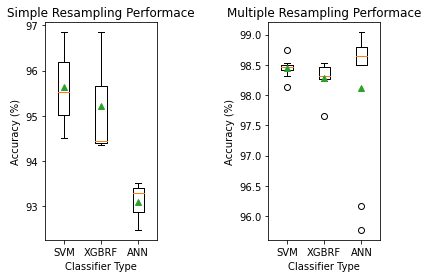

In [48]:
pyplot.subplot(1,2,1)
pyplot.boxplot([svm_sfk_score * 100,xgbrf_sfk_score * 100, ann_sfk_score * 100], labels=["SVM", "XGBRF", "ANN"] ,showmeans=True)
pyplot.title("Simple Resampling Performace")
pyplot.xlabel("Classifier Type")
pyplot.ylabel("Accuracy (%)")

pyplot.subplot(1,2,2)
pyplot.boxplot([svm_multiple_resampling_score * 100,xgbrf_multiple_resampling_score * 100, ann_multiple_resampling_score * 100], labels=["SVM", "XGBRF", "ANN"] ,showmeans=True)
pyplot.title("Multiple Resampling Performace")
pyplot.xlabel("Classifier Type")
pyplot.ylabel("Accuracy (%)")

pyplot.subplots_adjust(wspace = 1, hspace = 1)

pyplot.show()